# MNIST Example
Working on the MNIST dataset using Pytorch. Reference: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html

In [31]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim

### Data Download
Start by downloading data

In [32]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"


URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"


In [33]:

PATH.mkdir(parents=True, exist_ok=True)

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [34]:
import pickle
import gzip

# STored in pickle format

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

### Visualize Image
Visualize one image as an example

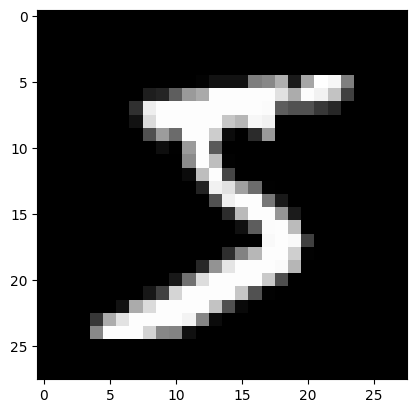

(50000, 784)


In [35]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

### Convert to Tensor
Convert all data to tensors

In [36]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Simple Model
Simple linear model for starters

In [37]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [38]:
print(weights.shape, bias.shape)

torch.Size([784, 10]) torch.Size([10])


##### Log Softmax

Log softmax involves taking log of softmax function. It simplifies to:

log(exp(xi)/sum(exp(xi)))
= xi - log(sum(exp(xi)))

In [39]:
def log_softmax(x): # Defining softmax 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [40]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.9673, -2.4502, -2.1798, -2.3435, -1.9450, -2.0987, -2.8484, -3.0085,
        -2.4255, -2.2682], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [41]:
torch.argmax(preds, dim=1) # Getting the digit predictions for each item in the mini-batch

tensor([4, 2, 5, 9, 2, 0, 9, 5, 9, 5, 5, 9, 5, 2, 2, 5, 2, 2, 2, 9, 2, 2, 9, 9,
        1, 2, 1, 5, 2, 2, 2, 5, 4, 5, 5, 5, 2, 5, 2, 2, 0, 2, 1, 2, 9, 5, 2, 4,
        3, 5, 2, 2, 1, 0, 5, 2, 2, 0, 1, 9, 2, 2, 2, 2])

In [42]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [43]:
preds[0,yb[0]] # We want the value for the target digit to be maximized.
# So we minimize the negative of this function. That is negative log likelihood loss.

tensor(-2.0987, grad_fn=<SelectBackward0>)

In [44]:
def nll(input, target): # negative log likelihood loss function
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [45]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3894, grad_fn=<NegBackward0>)


In [46]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.1094)


In [47]:
(n - 1) // bs + 1

782

In [48]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        # Getting the batch for current iteration
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        # Getting predictions (forward pass)
        pred = model(xb)

        # Getting loss
        loss = loss_func(pred, yb)

        # Automatic backward prop using pytorch
        loss.backward()

        # Updating weights
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 0, Loss: 0.4086224436759949
Epoch: 1, Loss: 0.3179773986339569


In [49]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0840, grad_fn=<NegBackward0>) tensor(1.)


In [50]:
torch.argmax(model(x_valid), dim=1) # Predictions for validation set

tensor([3, 8, 6,  ..., 5, 6, 8])

In [51]:
print(accuracy(model(x_valid), y_valid))

tensor(0.9184)


### Using nn
We implement the same model, but use nn this time.

##### Cross entropy:
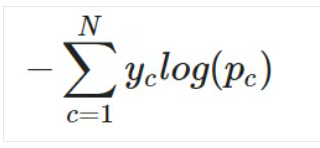

In [52]:
# Cross entropy combines log softmax activation and negative log likelihood loss

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [53]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([ 1.8322, -5.1054, -0.3486,  5.5526, -6.3383,  7.5136, -2.9305,  1.4946,
         0.5169, -1.1100], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [54]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        # Getting the batch for current iteration
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        # Getting predictions (forward pass)
        pred = model(xb)

        # Getting loss
        loss = loss_func(pred, yb)

        # Automatic backward prop using pytorch
        loss.backward()

        # Updating weights
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 0, Loss: 0.2728734314441681
Epoch: 1, Loss: 0.24328407645225525


In [55]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0665, grad_fn=<NllLossBackward0>) tensor(1.)


### Creating a custom class

Using nn.module to create a custom class for this model, so that we have a more concise training loop

In [56]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [57]:
# Initiate the model
model = Mnist_Logistic()

In [58]:
print(loss_func(model(xb), yb))

tensor(2.4211, grad_fn=<NllLossBackward0>)


In [59]:
# Now we can write our smaller training loop in a fit function

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward() #computes gradients
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr # updates parameters using gradients
                model.zero_grad()

fit()

In [60]:
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward0>)


### Refactor using Linear
We refactor the code again using pytorch's predefined linear layer, which we can define in our custom module as self.lin, and simply call it in the forward pass.

In [61]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [62]:
# Instantiate model
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3484, grad_fn=<NllLossBackward0>)


In [63]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward0>)


### Using Optim

Finally we make use of the optim class to automate parameter updation

In [64]:
from torch import optim
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3172, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)


### Tensor Dataset
Using pytorch's tensor dataset module, we can combine the X and y values into one object, which can be iterated over together.

In [65]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward0>)


### Dataloader
Automates the batch managing process.

In [66]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [67]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>)


### Validation
Using the validation set to check model accuracy

In [68]:
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [69]:
# (Note that we always call model.train() before training, and model.eval() before inference, because these are 
# used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behavior for these different phases.)
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3093)
1 tensor(0.2899)


### Creating Loss Batch

A function that calculates loss for one batch, to make it easier while calculating training and validation loss.

In [70]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [71]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # Average batch wise validation loss

        print(epoch, val_loss)

In [72]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [73]:
# Now the entire process is 3 lines of code!

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.28982295142412184
1 0.2905206575334072


### CNN
We use the same code to train a CNN, which we define using pytorch's conv2d module.

CNN Recap:
* **Kernel**: A axa matrix of weights applied on the input layer. Where 'a' is kernel size.
* **Stride**: How often the kernel is applied/how much we slide the kernel each time we apply it
* **Conv2d(x, b)**: x is depth of input layer (input channels), b is depth of output layer (output channels).
* **Output channels**: Say b is 2, then the kernel weight matrix will be axax2, with two different axa kernels for the two different output channels.
* **Pooling**: A layer that reduces the volume of the previous layer and makes calculations faster. Also has size axa and stride s like kernels. Max pooling takes the max value in an axa area and average pooling takes the average.

In [74]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # Input layer has only one channel, because bnw image
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1) # Input channel equals output channels of prev layer
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # pytorch version of reshape
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4) # Average pooling with size 4
        return xb.view(-1, xb.size(1)) # Flattening

lr = 0.1

##### Momentum
Takes previous updates into account and leads to faster training. Variation of sgd

In [75]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 2

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3207342226266861
1 0.261737695980072
